## Homework: Future Spread Dynamics

========================================================================================================================

### Richmond Frankeberger 12277572 

========================================================================================================================

#### Defining Data

Based on the assignment, the last two digits of the student ID will define which spreads to analyze. The below will apply for this worksheet.

W, X = 7

Y, Z = 2

7: CBT_TU_TU CBT_TY_TY

2: ICE_B_B   ICE_T_T

The first spread, #7, will be the 10y2y treasuries spread.
The second spread, #2, will be WTI-Brent crude oil spread.
Each spread will be referenced as $s_t^{(i)}$, where i references the identification number 7 or 2.

========================================================================================================================

#### Imports and Functions 

In [505]:
%matplotlib inline
from   matplotlib                import pyplot as plt
from   statsmodels.tsa.stattools import adfuller
from   statsmodels.tsa.seasonal  import seasonal_decompose
import pandas                    as     pd
import plotnine                  as     p9
import numpy                     as     np
import seaborn                   as     sns
import quandl
import scipy

In [337]:
### Use to download data from Quandl.
### Arguments: symbol: Enter database code and symbol code here. start and end refer to dates
def quandler(symbol,start,end):
    data = quandl.get(symbol, api_key = "hJrpPb7hMqbAvC9tkQZy", start_date = start, end_date = end)
    return data

In [506]:
### Provides basic statistics for a given dataset.
### Arguments: data: pass a dataframe q: level of significance for VaR/Shortfall
def statistics(data, q):
    df                                        = data.copy()
    df.index                                  = data.index.date
    report                                    = pd.DataFrame(columns = df.columns)
    report.loc['Mean']                        = df.mean()
    report.loc['Median']                      = df.median()
    report.loc['Min']                         = df.min()
    report.loc['Max']                         = df.max()
    report.loc[r'$\sigma$']                   = df.std()
    report.loc['Skewness']                    = df.skew()
    report.loc['Excess Kurtosis']             = df.kurtosis()
    report.loc['VaR (Quantile {})'.format(q)] = df.quantile(q)
    report.loc['VaR (Normal)']                = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']          = df[df     < df.quantile(q)].mean()
    report.loc['Expected Shortfall (Normal)'] = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    return round(report,4)

========================================================================================================================

#### Data Download and Wrangling

In [340]:
timeframe  = ['2020','2021']
contracts  = ['H','M','U','Z']
symbols    = ['OWF/ICE_T_T_','OWF/ICE_B_B_','OWF/CBT_TY_TY_','OWF/CBT_TU_TU_']
start_date = '2019-12-03'
end_date   = '2021-08-31'

In [324]:
def spreaddata(s):
    spreads         = pd.DataFrame()
    
    for t in timeframe:
        for c in contracts:
            x       = quandler(s + c + t + '_IVM',start_date, end_date)
            spreads = spreads.append(x)
            
    spreads         = spreads[spreads['DtT'] > 30]
    spreads         = spreads.reset_index().drop_duplicates(subset='Date')
    spreads         = spreads.set_index('Date')
    spreads         = spreads[spreads.columns[spreads.columns.str.contains('Future|DtT',regex=True)]]
    return            spreads

In [325]:
data_T_T   = spreaddata(symbols[0])
data_B_B   = spreaddata(symbols[1])
data_TY_TY = spreaddata(symbols[2])
data_TU_TU = spreaddata(symbols[3])

Data Quality Check

In [335]:
Spread_T_B = data_T_T[['Future']] - data_B_B[['Future']]
Spread_T_B['2021-01-19':'2021-01-20']

,Future
Date,
2021-01-19,-2.54
2021-01-20,-2.86


In [336]:
Spread_TY_TU = data_TY_TY[['Future']] - data_TU_TU[['Future']]
Spread_TY_TU['2021-02-18':'2021-02-19']

,Future
Date,
2021-02-18,25.382812
2021-02-19,23.871875


========================================================================================================================

#### Analysis

As a starting point, we can create a graph of the two spreads.

In [351]:
Spreads_7_2              = pd.DataFrame(index=Spread_T_B.index,columns = ['10y2y_UST', 'WTI-Brent'])
Spreads_7_2['10y2y_UST'] = Spread_TY_TU
Spreads_7_2['WTI-Brent'] = Spread_T_B

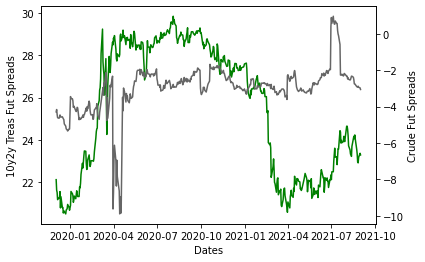

In [384]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()
ax1.plot(Spreads_7_2.index,Spreads_7_2['10y2y_UST'],'g')
ax2.plot(Spreads_7_2.index,Spreads_7_2['WTI-Brent'],'0.4')
ax1.set_xlabel('Dates')
ax1.set_ylabel('10y2y Treas Fut Spreads')
ax2.set_ylabel('Crude Fut Spreads')
plt.show()

##### General Observations

Treasury Fut spreads have been in the range of 22 - 30 cents on the dollar for the given timeframe. Crude Fut spreads have been negative, averaging about -3 dollars per barrel.

The Treasury Fut spread significantly increased at the onset of COVID (Q120) and stayed at elevated levels, while Crude spreads dived briefly before returning to median levels. As the US economy showed signs of recovery in Q121, 10y2y spreads tightened signficantly. In Q321, we see a rise in both spreads, probably around the time of the Omicron variant's ascendance, though the Crude spread returns back to previous levels relatively soon.

Other than the brief spike during COVID alpha, it appears that the two spreads are positively correlated. The magnitude of movements is much larger for the treasury fut spread. The crude spread may exhibit some stationarity/mean-reversion as well.

Let us first proceed with statistically analyzing the difference between spreads and their rolling averages, $d_t^{(N)}$, and then continue with any other reasonable tests. We will set rolling averages to span over weekly, bi-weekly, monthly, and quarterly observations (assuming 252 business days p.a.).

##### Analysis of $d_t^{(N)}$, where $d_t^{(N)} = s_t^{(i)} - RA_N$ and $N=[5,10,21,63]$

First calculate the diffs vs each rolling average for both Treasuries and Crude.

In [417]:
Spreads_7              = pd.DataFrame(index=Spread_T_B.index,columns = ['10y2y_UST'])
Spreads_7['10y2y_UST'] = Spread_TY_TU
Spreads_7              = Spreads_7.assign(
                                        MA_W   = Spread_TY_TU.rolling(5).mean(),
                                        MA_BW  = Spread_TY_TU.rolling(10).mean(),
                                        MA_M   = Spread_TY_TU.rolling(21).mean(),
                                        MA_Q   = Spread_TY_TU.rolling(63).mean()    
                                            )

Spreads_2              = pd.DataFrame(index=Spread_T_B.index,columns = ['WTI-Brent'])
Spreads_2['WTI-Brent'] = Spread_T_B
Spreads_2              = Spreads_2.assign(
                                        MA_W   = Spread_T_B.rolling(5).mean(),
                                        MA_BW  = Spread_T_B.rolling(10).mean(),
                                        MA_M   = Spread_T_B.rolling(21).mean(),
                                        MA_Q   = Spread_T_B.rolling(63).mean()    
                                            )

In [418]:
Spreads_7              = Spreads_7.assign(
                                        diff_W  = Spreads_7['10y2y_UST'] - Spreads_7['MA_W'],
                                        diff_BW = Spreads_7['10y2y_UST'] - Spreads_7['MA_BW'],
                                        diff_M  = Spreads_7['10y2y_UST'] - Spreads_7['MA_M'],
                                        diff_Q  = Spreads_7['10y2y_UST'] - Spreads_7['MA_Q']  
                                            )
Spreads_2              = Spreads_2.assign(
                                        diff_W  = Spreads_2['WTI-Brent'] - Spreads_2['MA_W'],
                                        diff_BW = Spreads_2['WTI-Brent'] - Spreads_2['MA_BW'],
                                        diff_M  = Spreads_2['WTI-Brent'] - Spreads_2['MA_M'],
                                        diff_Q  = Spreads_2['WTI-Brent'] - Spreads_2['MA_Q']  
                                            )

Below we plot the spread diffs vs the various rolling averages.

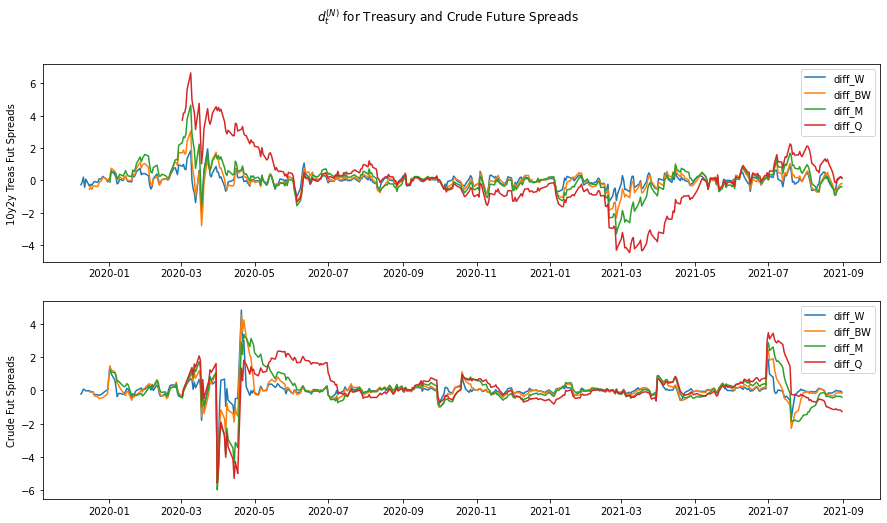

In [433]:
fig_Spreads_7, (fs7ax1, fs7ax2) = plt.subplots(2,figsize=(15,8))
fig_Spreads_7.suptitle('$d_t^{(N)}$ for Treasury and Crude Future Spreads')

fs7ax1.plot(Spreads_7.index,Spreads_7.iloc[:,-4:])
fs7ax1.set_ylabel('10y2y Treas Fut Spreads')
fs7ax1.legend(Spreads_7.columns[-4:])

fs7ax2.plot(Spreads_2.index,Spreads_2.iloc[:,-4:])
fs7ax2.set_ylabel('Crude Fut Spreads')
fs7ax2.legend(Spreads_2.columns[-4:])

##### Statistical Observations

Here we present tables summarizing the key statistics for the diffs, including median and standard deviation.

As a reminder: The first table is Spread_7, the treasury futures diff. The second table is Spread_2, the crude futures diff.

##### General Statistics

In [446]:
Spread_7_stats = statistics(Spreads_7.iloc[:,-4:],0.05)
Spread_7_stats.T

,Mean,Median,Min,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
diff_W,0.0082,0.0258,-2.0181,1.9444,0.3882,0.0239,4.4744,-0.5927,-0.6303,-0.8717,-0.7925
diff_BW,0.0222,0.0455,-2.8048,3.0470,0.5722,0.1223,4.8915,-0.8153,-0.9190,-1.3168,-1.1581
diff_M,0.0626,0.1089,-3.2958,4.6478,0.8522,0.2458,4.5521,-1.2859,-1.3392,-2.0374,-1.6953
diff_Q,0.0721,0.0230,-4.4613,6.6394,1.8107,0.2625,1.2216,-3.4907,-2.9062,-3.9464,-3.6629


In [447]:
Spread_2_stats = statistics(Spreads_2.iloc[:,-4:],0.05)
Spread_2_stats.T

,Mean,Median,Min,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal),Expected Shortfall,Expected Shortfall (Normal)
diff_W,0.0065,-0.0030,-5.5160,4.8300,0.5467,-0.5505,43.9854,-0.4485,-0.8928,-1.1655,-1.1212
diff_BW,0.0161,-0.0080,-5.5420,4.5440,0.7522,0.1477,17.0384,-0.8740,-1.2211,-1.8258,-1.5355
diff_M,0.0500,0.0212,-5.9786,3.3671,1.0082,-0.9189,7.1923,-1.4686,-1.6084,-2.7757,-2.0297
diff_Q,0.1841,-0.0070,-5.5719,3.4706,1.1926,-0.9661,5.2918,-1.0747,-1.7776,-2.9452,-2.2759


Spread_2, the crude spread, shows significantly higher kurtosis than the treasuries spread, especially for weekly diffs. This is somewhat intuitive given the tight movements we saw on average in the first graph for the outright WTI-Brent spread.

Another interesting observation is that the vol for treasury futures is larger on a quarterly basis than crude, which is otherwise more volatile. 

Overall, it appears that the Treasuries spread is more susceptible to larger losses given the low mean, positive skew, and large VaR/ES. However if one isn't limited to B/S constraints or short to medium term losses, the median spread on treasuries is higher and there may be more opportunities to profit depending on point of entry.

##### Correlation

<AxesSubplot:>

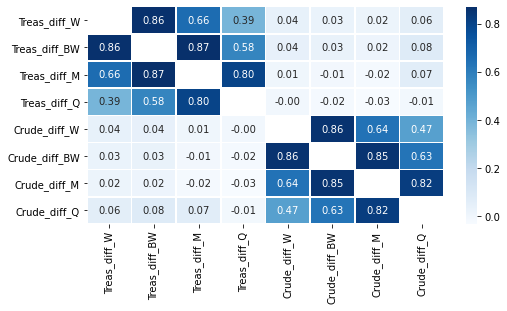

In [503]:
All_d_Spreads = Spreads_7.iloc[:,-4:].rename(columns = {'diff_W':'Treas_diff_W', 'diff_BW':'Treas_diff_BW','diff_M':'Treas_diff_M','diff_Q':'Treas_diff_Q'})
All_d_Spreads = All_Spreads.assign(
                Crude_diff_W  = Spreads_2['diff_W'],
                Crude_diff_BW = Spreads_2['diff_BW'],
                Crude_diff_M  = Spreads_2['diff_M'],
                Crude_diff_Q  = Spreads_2['diff_Q']
                )

Corr_Table                  = All_d_Spreads.corr()
Corr_Table[Corr_Table == 1] = None
plt.figure(figsize = (8,4))
sns.heatmap(Corr_Table,annot=True,fmt = '.2f',cmap='Blues',linewidths=0.5)

The correlation table above shows that correlations per product are high across rolling averages, which can be expected. When comparing across Crude and Treasuries, we see that correlations are close to zero. They are slightly positive across all of the groups, except with respect to Quarterly Treasury spreads. This was the dataset for which we observed interesting statistical characteristics above as well - it appears to have unique properties on multiple fronts.

##### Stationarity

In [495]:
for i in All_d_Spreads.columns.to_list():
    print("Dataset: {}\nP-value: {:.2f}\nStationary?: {}".format(i,adfuller(All_d_Spreads.loc[:,i].dropna())[1],"Yes" if adfuller(All_d_Spreads.loc[:,i].dropna())[1] < 0.05 else "No"))

Dataset: Treas_diff_W
P-value: 0.00
Stationary?: Yes
Dataset: Treas_diff_BW
P-value: 0.00
Stationary?: Yes
Dataset: Treas_diff_M
P-value: 0.02
Stationary?: Yes
Dataset: Treas_diff_Q
P-value: 0.11
Stationary?: No
Dataset: Crude_diff_W
P-value: 0.00
Stationary?: Yes
Dataset: Crude_diff_BW
P-value: 0.00
Stationary?: Yes
Dataset: Crude_diff_M
P-value: 0.00
Stationary?: Yes
Dataset: Crude_diff_Q
P-value: 0.01
Stationary?: Yes


As expected, we find that all Crude $d_t^{(N)}$ is stationary. For Treasuries, we again find that the quarterly spread is an outlier - it is the only non-stationary variable in this dataset.

What if we compare outright spreads $s_t^{(N)}$?

In [500]:
for i in Spreads_7_2.columns.to_list():
    print("Dataset: {}\nP-value: {:.2f}\nStationary?: {}".format(i,adfuller(Spreads_7_2.loc[:,i].dropna())[1],"Yes" if adfuller(Spreads_7_2.loc[:,i].dropna())[1] < 0.05 else "No"))

Dataset: 10y2y_UST
P-value: 0.52
Stationary?: No
Dataset: WTI-Brent
P-value: 0.02
Stationary?: Yes


We confirm that there is stationarity for Crude on the raw spread, while Treasuries are non-stationary.

After looking at both $d_t^{(N)}$ and $s_t^{(N)}$ in terms of stationarity, we can see that at least in the short term - i.e. weekly to monthly, the spreads tend to have a tendency to mean-revert.

##### Seasonality and Residual Components

Below we show disect $d_t^{(N)}$ to disect the seasonality component for monthly and quarterly $N$. Seasonality itself appears to be a small absolute component of $d_t^{(N)}$, even for quarterly crude -  where demand for crude in general should be bigger in cold months. The large residuals exhibit stationarity across datasets.

We can also clearly see the non-stationarity in the trend element for Treasury Fut diffs.

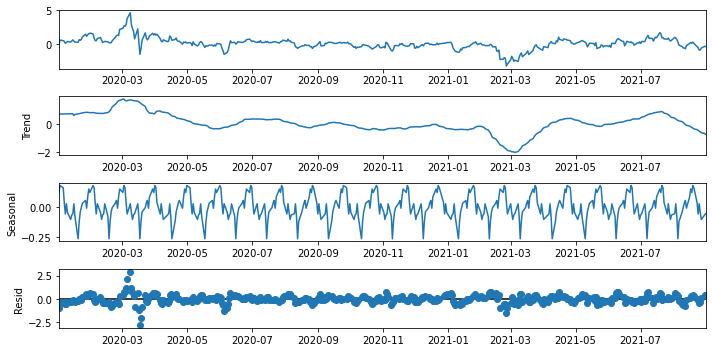

Residuals are stationary.
P-value=0.00


In [560]:
Treas_Season_M = seasonal_decompose(Spreads_7.iloc[:,[-2]].dropna(), model = 'additive',extrapolate_trend = 'freq', period = 21)
plt.rcParams['figure.figsize'] = [10,5]
Treas_Season_M.plot()
plt.show()
print("Residuals are stationary.\nP-value={:.2f}".format(adfuller(Treas_Season_M.resid.dropna())[1]) if adfuller(Treas_Season_M.resid.dropna())[1] < 0.05 else "Residuals are non-stationary.")

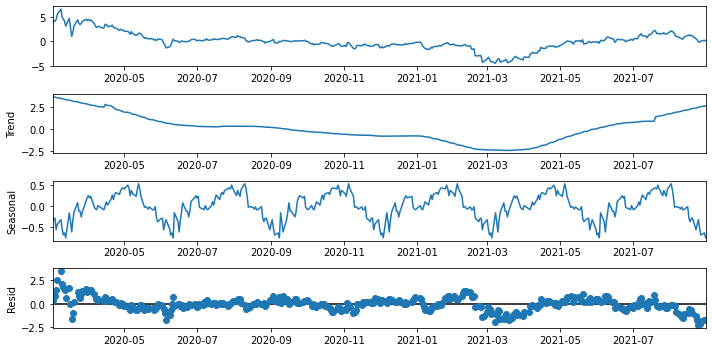

Residuals are stationary.
P-value=0.00


In [566]:
Treas_Season_Q = seasonal_decompose(Spreads_7.iloc[:,[-1]].dropna(), model = 'additive',extrapolate_trend = 'freq', period = 63)
plt.rcParams['figure.figsize'] = [10,5]
Treas_Season_Q.plot()
plt.show()
print("Residuals are stationary.\nP-value={:.2f}".format(adfuller(Treas_Season_Q.resid.dropna())[1]) if adfuller(Treas_Season_Q.resid.dropna())[1] < 0.05 else "Residuals are non-stationary.")

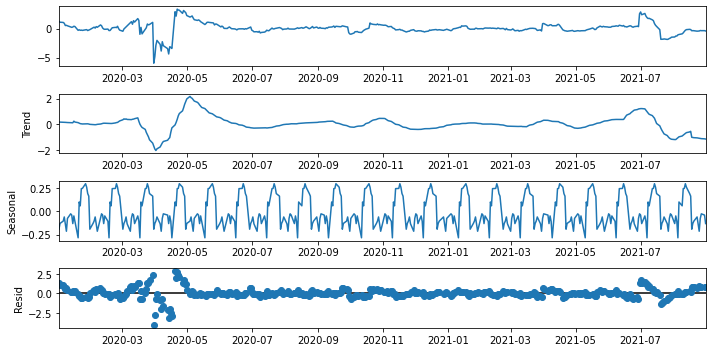

Residuals are stationary.
P-value=0.00


In [562]:
Oil_Season_M = seasonal_decompose(Spreads_2.iloc[:,[-2]].dropna(), model = 'additive',extrapolate_trend = 'freq', period = 21)
plt.rcParams['figure.figsize'] = [10,5]
Oil_Season_M.plot()
plt.show()
print("Residuals are stationary.\nP-value={:.2f}".format(adfuller(Oil_Season_M.resid.dropna())[1]) if adfuller(Oil_Season_M.resid.dropna())[1] < 0.05 else "Residuals are non-stationary.")

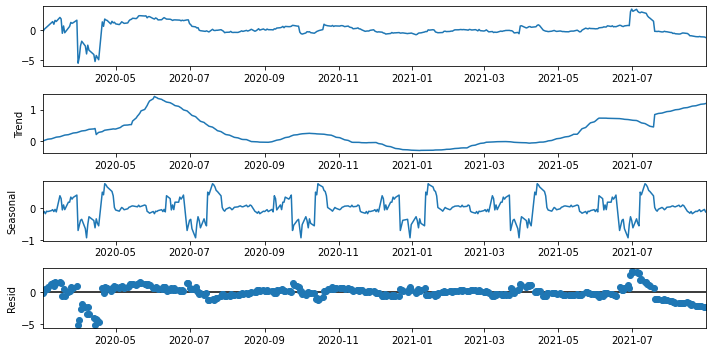

Residuals are stationary.
P-value=0.00


In [563]:
Oil_Season_Q = seasonal_decompose(Spreads_2.iloc[:,[-1]].dropna(), model = 'additive',extrapolate_trend = 'freq', period = 63)
plt.rcParams['figure.figsize'] = [10,5]
Oil_Season_Q.plot()
plt.show()
print("Residuals are stationary.\nP-value={:.2f}".format(adfuller(Oil_Season_Q.resid.dropna())[1]) if adfuller(Oil_Season_Q.resid.dropna())[1] < 0.05 else "Residuals are non-stationary.")

========================================================================================================================

### Conclusion

The 10y2y US Treasury Fut spread and the WTI-Brent Crude Fut spread exhibit statistical properties that make them relatable. Both spreads exhibit stationarity in the short term (one month investment horizon or less), high vol per mean (very low Sharpe), and high kurtosis. The correlation between the two spreads is close to zero, and slightly positive for short term horizons. Positive skew is consistent for the Treasury spread as well.

These statistical properties do not appear to show any strategic trading opportunities.

One can try a mean-reversion strategy, where if spreads move x amount of vols away from the short-term mean, enter into a mean reverting tightener or widener funded at the repo rate, in either spread. Given the close-to-zero correlation, there should be no issue in entering both markets at the same time - except for market shocks such as COVID19/Omnicron which would spike correlations across the board. As a hedge, one can go long vol on the outright underlier(s).